In [1]:
import numpy as np
import os, glob
from math import *
import random
from graphviz import Graph
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as ticker
import matplotlib.animation as animation

%matplotlib inline
MAX_child = 3
MAX_try = 3

<Figure size 864x864 with 0 Axes>

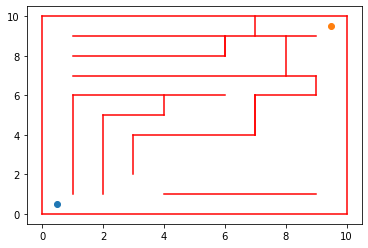

In [2]:
N = 10
plt.figure(figsize = (12,12))
fig = plt.figure()
tate_wall = [[0,0,0,10], [10,10,0,10], [1,1,1,6],[2,2,1,5], [4,4,5,6],[3,3,2,4],[6,6,8,9], [7,7,4,6], [7,7,9,10],[8,8,7,9],[9,9,6,7]]
yoko_wall = [[0,10,0,0],[0, 10, 10,10],  [1,6,6,6], [1,9,7,7], [1,9, 9,9], [1,6,8,8],[2,4,5,5],[4,9,1,1],  [3,7,4,4], [6,6,8,9], [7,7,4,6], [7,9, 6,6]]
for w in tate_wall:
    plt.plot(w[0:2], w[2:4],c = 'r')
for w in yoko_wall:
    plt.plot(w[0:2], w[2:4],c = 'r')
    
plt.plot(0.5, 0.5 ,marker = 'o') # スタート
plt.plot(9.5, 9.5, marker='o')   # ゴール

# ぶつかり判定用array
tate_wall_array = np.zeros([11,10])
yoko_wall_array = np.zeros([11,10])
for w in tate_wall:
    x = w[0]
    y_i, y_j = w[2:4]
    for y in range(y_i, y_j):
        tate_wall_array[x, y ] += 1
        
for w in yoko_wall:
    y = w[3]
    x_i, x_j = w[0:2]
    for x in range(x_i, x_j):
        yoko_wall_array[y, x ] += 1

In [3]:

import numpy as np
import os, glob
from math import *
import random
from graphviz import Graph
MAX_child = 3
MAX_try = 10

goal = np.array([9,9])
class Node:
    def __init__(self, move = None, parent = None, state = None, depth = 0):
        self.parentNode = parent # "None" for the root node
        self.childNodes = []
        self.depth = depth
        self.child_depth = 0
        self.rmsd_sum = 0
        self.rmsd_max = -162 # 初期値
        self.visits = 0
        self.state = state
        self.untriedMoves = MAX_child
        self.c = 20
        self.alpha = 50
        self.rmsd = 162 # 初期値
        self.try_num = 0
        if self.parentNode != None:
            self.ix = self.parentNode.ix
            self.iy = self.parentNode.iy
        else:
            self.ix = 0
            self.iy = 0

    def UCTSelectChild(self):
        child_rmsds = [ch.rmsd_max for ch in self.childNodes]
        rmsd_diff = max(child_rmsds) - min(child_rmsds)
        child_depths = [ch.child_depth for ch in self.childNodes]
        # depth_diff = max(child_depths) - min(child_depths)
        c = max(0.01, rmsd_diff * self.alpha)
        # s = sorted(self.childNodes, key = lambda ch: ch.rmsd_max + self.c * sqrt(2*log(self.visits)/ch.visits))[-1]
        s = sorted(self.childNodes, key = lambda ch: ch.rmsd_max + c * sqrt(2*log(self.visits)/ch.visits))[-1] # RMSDの差に比例してCを定める方式
        
        return s

    def CalcUCT(self):
        pnd = self.parentNode
        if pnd == None:
            return -1
        child_rmsds = [ch.rmsd_max for ch in pnd.childNodes]
        rmsd_diff = max(child_rmsds) - min(child_rmsds)
        c = rmsd_diff * self.alpha
        uct = self.rmsd_max + c * sqrt(2*log(pnd.visits) / self.visits)
        return uct
    
    def MakeChild(self, s, d):
        n = Node(parent = self, state = s, depth = d)
        return n

    def AddChild(self, n):
        # n = Node(parent = self, state = s)
        self.untriedMoves -= 1
        self.childNodes.append(n)
        return n
    
    def DeleteChild(self, n):
        delete_i = -1
        for ch_i, ch in enumerate(self.childNodes):
            if ch.state == n.state:
                delete_i = ch_i
                break
        self.childNodes.pop(delete_i)
        self.untriedMoves += 1

    def SearchMaxRmsd(self):
        child_rmsds = [ch.rmsd_max for ch in self.childNodes]
        if child_rmsds != []:
            self.max_rmsd = max(child_rmsds)
        else:
            self.max_rmsd = -1000

    def Update(self, result, d):
        self.visits += 1
        self.rmsd_sum += result
        if result > self.rmsd_max:
            self.rmsd_max = result
        if d > self.child_depth:
            self.child_depth = d
            
    def MDrun(self):
        state = self.state
        pstate = self.parentNode.state
        self.parentNode.try_num += 1
        ix, iy  = self.ix, self.iy
        min_rmsd = self.parentNode.rmsd       
        vx, vy = [[0,1],[0,-1],[1,0],[-1,0]][np.random.randint(4)]
        if vx == 0: # y軸方向に移動
            if vy == 1:
                wall = yoko_wall_array[iy+1, ix]
            else:
                wall = yoko_wall_array[iy, ix]
        else:          # x軸方向に移動
            if vx == 1: 
                wall = tate_wall_array[ix+1, iy]
            else:
                wall = tate_wall_array[ix, iy]
        if wall == 0:
            self.ix = ix + vx
            self.iy = iy + vy    
        rmsd = np.sum(((goal - [self.ix, self.iy])) ** 2)
        self.rmsd = rmsd
        return rmsd

In [6]:
def UCT(rootstate, itermax, verbose = False):
    rootnode = Node(state = rootstate)
    n_state = 0
    
    x_list = []

    max_rmsd = -10000
    max_node    = rootnode
    o = open('log_mcts.txt','w')
    o.close()
    near_count = 0
    for i in range(itermax):
        o = open('log_mcts.txt','a')
        node = rootnode
        state = rootstate
        flag = 0
        # Select
        while (node.untriedMoves == 0 or node.try_num >= MAX_try) and node.childNodes != []: # node is fully expanded and non-terminal
            node = node.UCTSelectChild()
            state = node.state

        # Expand
        parent_node =node
        parent_rmsd = node.rmsd
        parent_depth = node.depth
        state = n_state + 1
        depth = parent_depth + 1
        node = node.MakeChild(s = state, d = depth)
        result = node.MDrun()
        if result < parent_rmsd and [node.ix, node.iy] not in x_list: # RMSDが減少した場合のみexpandする
            parent_node.AddChild(node)
            n_state += 1
        else:
            flag = 1
        x_list.append([node.ix, node.iy]) # アニメーション用に進んだ位置を記録
        
        # Backpropagate
        result = -1 * result
        if result > max_rmsd:
            max_rmsd = result
            max_node = node
        while node != None:
            node.Update(result, depth)
            node = node.parentNode
                
        o.write(str(-1 * max_rmsd) + '\n')
        o.close()
        if i % 100 == 0:
            print(i)
            G = Graph(format='png')
            G.attr('node', shape='circle')
            G.graph_attr.update(size="320")
#             make_graph(G,rootnode)
            G.render('./tree/tree_' + str(i) + 'epoch')
        if max_rmsd == 0:
            print('finished')
            break
    
    # アニメーション描画用関数
    def update(i):
        if i == 0:
            for w in tate_wall:
                plt.plot(w[0:2], w[2:4],c = 'r')
            for w in yoko_wall:
                plt.plot(w[0:2], w[2:4],c = 'r')
            plt.plot(0.5, 0.5 ,marker = 'o')
            plt.plot(9.5, 9.5, marker='o')
        else:
            plt.plot(x_list[i-1][0] + 0.5 + np.random.random() / 10, x_list[i-1][1] + 0.5 + np.random.random() / 10, marker='.', c = 'r', alpha = 0.5)
        plt.xlim((0,N))
        plt.ylim(0,N)
        
    fig = plt.figure()
    ani = animation.FuncAnimation(fig, update, frames = len(x_list) + 1,interval = 10)
    ani.save('test.mp4', writer='ffmpeg')

# Tree描画用関数
def make_graph(G, nd):
    state = nd.state
    uct = nd.CalcUCT()
    G.node(str(state), str(nd.rmsd_max) + '\n' + "{:.4}".format(float(nd.rmsd))  + '\n' + str(nd.ix) + ' ' + str(nd.iy) + '\n' + str(nd.visits) + '\n' + str(uct))
    parent_node = nd.parentNode
    if parent_node != None:
        parent_state = parent_node.state
        G.edge(str(parent_state), str(state))
    for child_node in nd.childNodes:
        make_graph(G,child_node)

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
finished


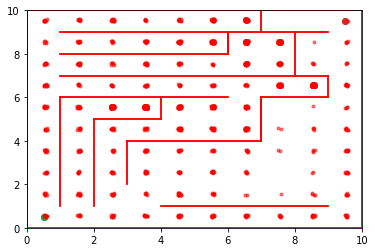

In [10]:
# 実行
UCT(0,3000)